In [21]:
%matplotlib inline

In [22]:
import os
from IPython.display import Image
from glob import glob
from nipype.pipeline import engine as pe
from nipype.interfaces import utility as niu
from nipype.workflows.dmri import dtitk as wfdtitk
import nipype.interfaces.io as nio
import nipype.interfaces.dtitk as dtitk
from dipy.viz import regtools
from nipype import MapNode
import nibabel as nib

In [23]:
def showme(static, moving, savebasename=False):
    static = nib.load(static).get_data()
    moving = nib.load(moving).get_data()
    if savebasename:
        regtools.overlay_slices(static, moving, None, 0, "Static", "Moving", savebasename+"_sag.png")
        regtools.overlay_slices(static, moving, None, 1, "Static", "Moving", savebasename+"_cor.png")
        regtools.overlay_slices(static, moving, None, 2, "Static", "Moving", savebasename+"_ax.png")
    else:
        regtools.overlay_slices(static, moving, None, 0, "Static", "Moving")
        regtools.overlay_slices(static, moving, None, 1, "Static", "Moving")
        regtools.overlay_slices(static, moving, None, 2, "Static", "Moving")

In [24]:
data_basepath = '../../ref_data/test_tensors/'
fixed_tensor = os.path.abspath(os.path.join(
    data_basepath, 'Ptensor.nii.gz'))
moving_tensor = os.path.abspath(os.path.join(
    data_basepath, 'Ttensor.nii.gz'))

child_example = os.path.abspath(os.path.join(
    data_basepath, 'child1_SC_EC_tensor.nii.gz'))
child_example2 = os.path.abspath(os.path.join(
    data_basepath, 'child2_SC_EC_tensor.nii.gz'))

In [25]:
wd = "working_WFtest"

## Define nodes

In [26]:
inputnode_rescan = pe.Node(niu.IdentityInterface(
                    fields=['fixed_file', 'moving_file']),
                    name='inputnode_rescan')
inputnode_rescan.inputs.fixed_file = fixed_tensor
inputnode_rescan.inputs.moving_file = moving_tensor

inputnode_adultchild = inputnode_rescan.clone(
    name='inputnode_adultchild')
inputnode_adultchild.inputs.moving_file = child_example

In [27]:
# Inputs
inputnode = pe.Node(niu.IdentityInterface(
                    fields=['fixed_file', 'moving_file', 'sinkname']),
                    name='inputnode')

# Datasink
datasink1 = pe.Node(nio.DataSink(), name="datasink1")
datasink1.inputs.base_directory = os.path.abspath('datasinker')
datasink1.inputs.container = 'linear_datasink/'

datasink2 = datasink1.clone(name='datasink2')
datasink2.inputs.container = 'nonlinear_datasink'

datasink3 = datasink1.clone(name='datasink3')
datasink3.inputs.container = 'childchild_datasink'

# Test workflows
linearnode = wfdtitk.affine_tensor_pipeline()
nlinearnode = wfdtitk.diffeomorphic_tensor_pipeline()

# need these for display QC
fa_out = pe.Node(dtitk.TVtool(in_flag='fa'), name='fa_out')
fa_in = fa_out.clone(name='fa_in')

## Linear workflow

In [28]:
linear_wf = pe.Workflow(name="linear_wf", base_dir="working_WFtest")

linear_wf.connect(inputnode, 'fixed_file', 
                  linearnode, 'inputnode.fixed_file')
linear_wf.connect(inputnode, 'moving_file', 
                  linearnode, 'inputnode.moving_file')
linear_wf.connect(linearnode, 'outputnode.out_file', 
                  datasink1, 'warped_file.@file')
linear_wf.connect(linearnode, 'outputnode.out_file_xfm', 
                  datasink1, 'warp_xfm.@xfm')

linear_wf.connect(linearnode, 'outputnode.out_file', 
                  fa_out, 'in_file')
linear_wf.connect(inputnode, 'fixed_file', 
                  fa_in, 'in_file')
linear_wf.connect(fa_out, 'out_file', 
                  datasink1, 'qc.qc_post.@warped_fa')
linear_wf.connect(fa_in, 'out_file', 
                  datasink1, 'qc.qc_pre.@warped_fa')

180429-00:09:59,48 workflow INFO:
	 Generated workflow graph: working_WFtest/linearwf.png (graph2use=colored, simple_form=True).


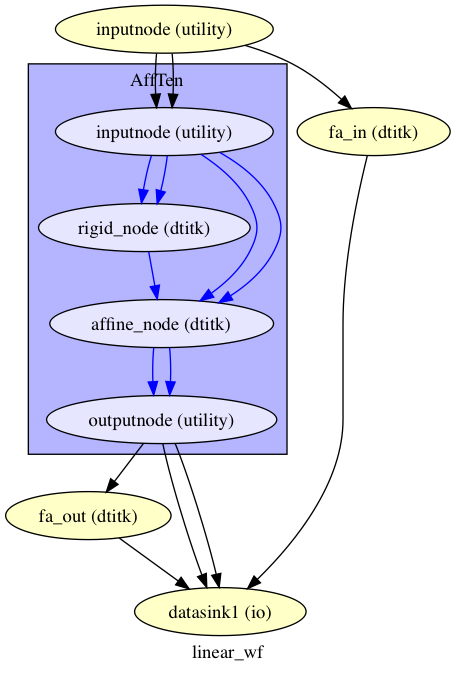

In [29]:
linear_wf.write_graph(dotfilename='working_WFtest/linearwf.dot', 
               graph2use='colored')
Image(filename='working_WFtest/linearwf.png')

### Scan Rescan

In [33]:
linear_wf.inputs.inputnode.fixed_file = fixed_tensor
linear_wf.inputs.inputnode.moving_file = moving_tensor
linear_wf.run()

180429-00:10:23,330 workflow INFO:
	 Workflow linear_wf settings: ['check', 'execution', 'logging', 'monitoring']
180429-00:10:23,344 workflow INFO:
	 Running serially.
180429-00:10:23,345 workflow INFO:
	 [Node] Setting-up "linear_wf.AffTen.rigid_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/AffTen/rigid_node".
180429-00:10:23,348 workflow INFO:
	 [Node] Cached "linear_wf.AffTen.rigid_node" - collecting precomputed outputs
180429-00:10:23,349 workflow INFO:
	 [Node] "linear_wf.AffTen.rigid_node" found cached.
180429-00:10:23,351 workflow INFO:
	 [Node] Setting-up "linear_wf.AffTen.affine_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/AffTen/affine_node".
180429-00:10:23,355 workflow INFO:
	 [Node] Cached "linear_wf.AffTen.affine_node" - collecting precomputed outputs
180429-00:10:23,356 workflow INFO:
	 [Node] "linear_wf.AffTen.affine_node" found cached.
180429-00:10:23,358 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_

Scan-Rescan Linear Registration

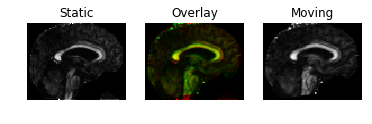

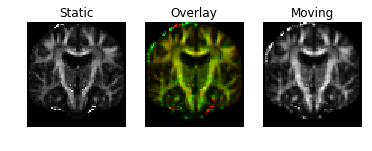

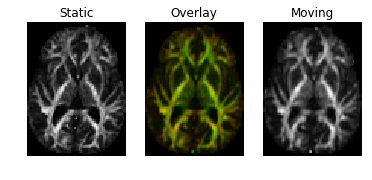

In [34]:
showme('datasinker/linear_datasink/qc/qc_pre/Ptensor_fa.nii.gz',
      'datasinker/linear_datasink/qc/qc_post/Ttensor_aff_fa.nii.gz')

### Adult Fixed, Child Moving

In [35]:
linear_wf_child = pe.Workflow(name="linear_wf_child", base_dir="working_WFtest")

linear_wf_child.connect(inputnode, 'fixed_file', 
                  linearnode, 'inputnode.fixed_file')
linear_wf_child.connect(inputnode, 'moving_file', 
                  linearnode, 'inputnode.moving_file')
linear_wf_child.connect(linearnode, 'outputnode.out_file', 
                  datasink1, 'warped_file.@file')
linear_wf_child.connect(linearnode, 'outputnode.out_file_xfm', 
                  datasink1, 'warp_xfm.@xfm')

linear_wf_child.connect(linearnode, 'outputnode.out_file', 
                  fa_out, 'in_file')
linear_wf_child.connect(inputnode, 'fixed_file', 
                  fa_in, 'in_file')
linear_wf_child.connect(fa_out, 'out_file', 
                  datasink1, 'qc.qc_post.@warped_fa')
linear_wf_child.connect(fa_in, 'out_file', 
                  datasink1, 'qc.qc_pre.@warped_fa')

linear_wf_child.inputs.inputnode.fixed_file = fixed_tensor
linear_wf_child.inputs.inputnode.moving_file = child_example
linear_wf_child.run()

180429-00:10:25,599 workflow INFO:
	 Workflow linear_wf_child settings: ['check', 'execution', 'logging', 'monitoring']
180429-00:10:25,609 workflow INFO:
	 Running serially.
180429-00:10:25,611 workflow INFO:
	 [Node] Setting-up "linear_wf_child.AffTen.rigid_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf_child/AffTen/rigid_node".
180429-00:10:25,613 workflow INFO:
	 [Node] Cached "linear_wf_child.AffTen.rigid_node" - collecting precomputed outputs
180429-00:10:25,614 workflow INFO:
	 [Node] "linear_wf_child.AffTen.rigid_node" found cached.
180429-00:10:25,615 workflow INFO:
	 [Node] Setting-up "linear_wf_child.AffTen.affine_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf_child/AffTen/affine_node".
180429-00:10:25,620 workflow INFO:
	 [Node] Cached "linear_wf_child.AffTen.affine_node" - collecting precomputed outputs
180429-00:10:25,621 workflow INFO:
	 [Node] "linear_wf_child.AffTen.affine_node" found cached.
180429-00:10:25

Post Registration (Linear) Child to Adult

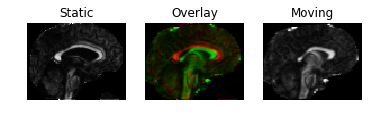

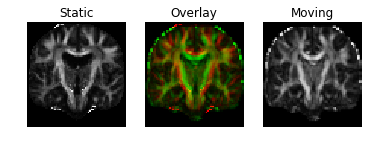

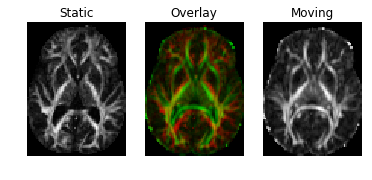

In [37]:
showme('datasinker/linear_datasink/qc/qc_pre/Ptensor_fa.nii.gz',
      'datasinker/linear_datasink/qc/qc_post/child1_SC_EC_tensor_aff_fa.nii.gz')

## Nonlinear 

In [38]:
nonlinear_wf = pe.Workflow(name='nonlinear_wf', 
                           base_dir="working_WFtest")

# Extra nodes for resliced images
fa_fix = fa_out.clone(name='fa_fix')
fa_mov = fa_out.clone(name='fa_mov')

In [39]:
nonlinear_wf.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf.connect(nlinearnode, 'outputnode.out_file', datasink2, 'warped_file.@file')
nonlinear_wf.connect(nlinearnode, 'outputnode.out_file_xfm', datasink2, 'warp_xfm.@xfm')
nonlinear_wf.connect(nlinearnode, 'outputnode.fixed_resliced', datasink2, 'qc.resliced.fixed.@im')
nonlinear_wf.connect(nlinearnode, 'outputnode.moving_resliced', datasink2, 'qc.resliced.moving.@im')


nonlinear_wf.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf.connect(fa_out, 'out_file', datasink2, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf.connect(fa_in, 'out_file', datasink2, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf.connect(fa_fix, 'out_file', datasink2, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf.connect(fa_mov, 'out_file', datasink2, 'qc.fa.qc_movreslice.@im')

180429-00:10:45,81 workflow INFO:
	 Generated workflow graph: working_WFtest/nonlinear.png (graph2use=colored, simple_form=True).


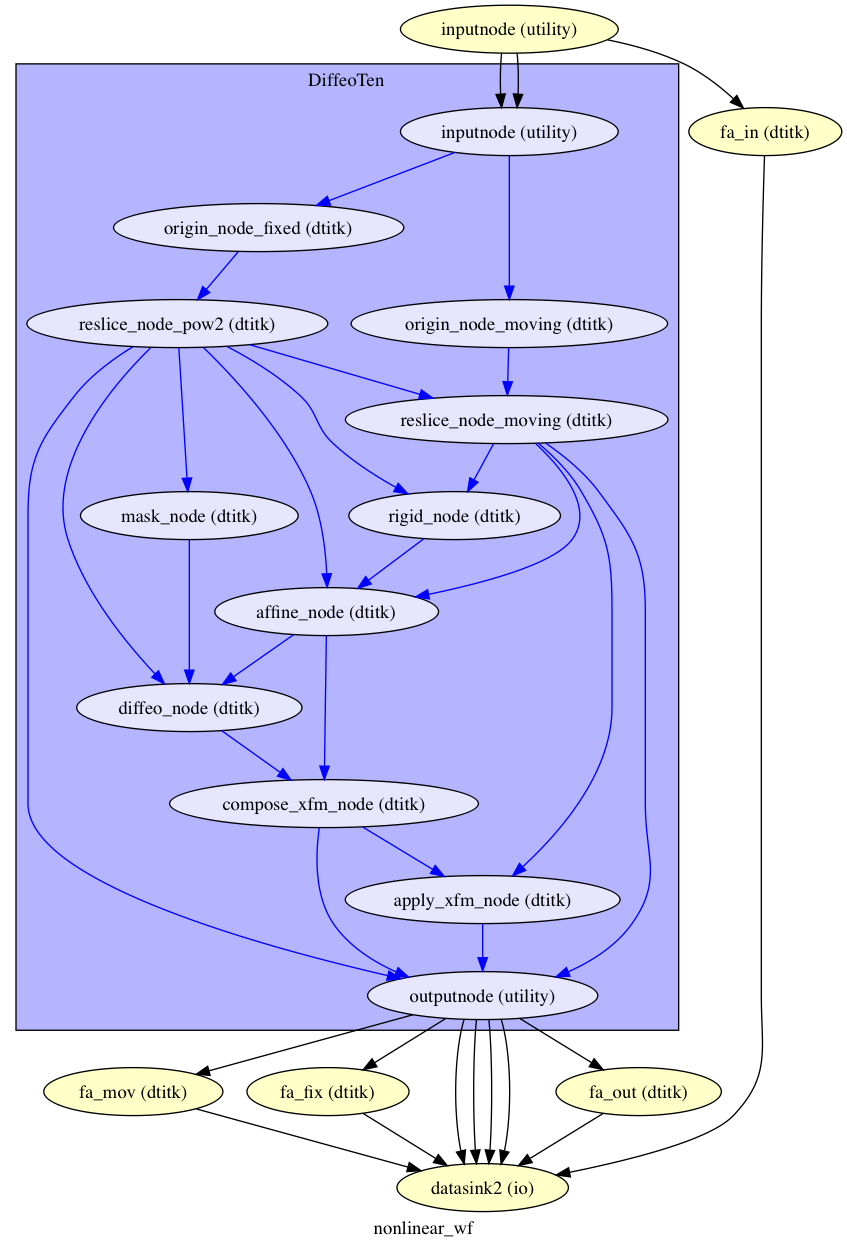

In [40]:
nonlinear_wf.write_graph(dotfilename='working_WFtest/nonlinear.dot', 
               graph2use='colored')
Image(filename='working_WFtest/nonlinear.png')

In [41]:
nonlinear_wf.inputs.inputnode.fixed_file = fixed_tensor
nonlinear_wf.inputs.inputnode.moving_file = moving_tensor
nonlinear_wf.run()

180429-00:10:46,953 workflow INFO:
	 Workflow nonlinear_wf settings: ['check', 'execution', 'logging', 'monitoring']
180429-00:10:46,977 workflow INFO:
	 Running serially.
180429-00:10:46,979 workflow INFO:
	 [Node] Setting-up "nonlinear_wf.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/origin_node_moving".
180429-00:10:46,988 workflow INFO:
	 [Node] Running "origin_node_moving" ("nipype.interfaces.dtitk.utils.TVAdjustVoxSp"), a CommandLine Interface with command:
TVAdjustVoxelspace -in /Users/kesshijordan/ref_data/test_tensors/Ttensor.nii.gz -origin 0 0 0 -out Ttensor_avs.nii.gz
180429-00:10:47,101 interface INFO:
	 stdout 2018-04-29T00:10:47.101325:Reading /Users/kesshijordan/ref_data/test_tensors/Ttensor.nii.gz ... Done in 0.034235s
180429-00:10:47,108 interface INFO:
	 stderr 2018-04-29T00:10:47.108215:WARNING: qform not defined
180429-00:10:47,112 interface INFO:
	 stderr 2018-04-29T00:10:47.108215:WARNING: assume

180429-00:10:53,72 interface INFO:
	 stdout 2018-04-29T00:10:53.071926:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/rigid_node/Ttensor_avs_resampled.nii.gz ... Done in 0.0714s
180429-00:10:53,890 interface INFO:
	 stdout 2018-04-29T00:10:53.890745:Gaussian smoothing: sigma = [0.736, 0.736, 0.736] ... Done in 0.443s
180429-00:10:54,260 interface INFO:
	 stdout 2018-04-29T00:10:54.260898:Initial Difference = 9.94e+05
180429-00:10:54,262 interface INFO:
	 stdout 2018-04-29T00:10:54.260898:initial estimate provided by center of mass alignment
180429-00:10:54,315 interface INFO:
	 stdout 2018-04-29T00:10:54.315103:cgm optimizer ftol = 0.01
180429-00:10:54,565 interface INFO:
	 stdout 2018-04-29T00:10:54.565722:both iteration 0 : 7.75e+05
180429-00:10:55,348 interface INFO:
	 stdout 2018-04-29T00:10:55.348758:both iteration 1 : 4.69e+05
180429-00:10:55,913 interface INFO:
	 stdout 2018-04-29T00:10:55.913229:both iteration 2 : 4.48e+05
180429-00:10:

180429-00:11:03,880 interface INFO:
	 stdout 2018-04-29T00:11:03.880881:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/affine_node/Ttensor_avs_resampled.nii.gz ... Done in 0.079969s
180429-00:11:04,101 interface INFO:
	 stdout 2018-04-29T00:11:04.101497:trans (inverse) applied = [19.564, -20.412, 10.915]
180429-00:11:04,102 interface INFO:
	 stdout 2018-04-29T00:11:04.101497:[ 1.002, -0.140, -0.020;  0.139,  0.982,  0.132; -0.004, -0.142,  1.018]
180429-00:11:04,103 interface INFO:
	 stdout 2018-04-29T00:11:04.101497:reading output volume specification from /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/affine_node/Ptensor_avs_resampled.nii.gz
180429-00:11:04,790 interface INFO:
	 stdout 2018-04-29T00:11:04.790891:backward resampling ...time consumed = 0.460
180429-00:11:05,655 interface INFO:
	 stdout 2018-04-29T00:11:05.655588:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/Diff

180429-00:11:28,382 interface INFO:
	 stdout 2018-04-29T00:11:28.382138:before : sum = 1177.43, img = 19029.3, prior = 224.505, reg = 330.523
180429-00:11:28,904 interface INFO:
	 stdout 2018-04-29T00:11:28.904870:iter 0: sum = 1177.43, img = 19029.3, prior = 224.505, reg = 330.523
180429-00:11:30,70 interface INFO:
	 stdout 2018-04-29T00:11:30.070197:iter 1: sum = 1160.18, img = 18730.8, prior = 210.483, reg = 382.229
180429-00:11:31,28 interface INFO:
	 stdout 2018-04-29T00:11:31.028192:iter 2: sum = 1154.7, img = 18719.6, prior = 210.125, reg = 262.761
180429-00:11:32,13 interface INFO:
	 stdout 2018-04-29T00:11:32.013618:iter 3: sum = 1147.85, img = 18447.2, prior = 220.663, reg = 473.949
180429-00:11:32,983 interface INFO:
	 stdout 2018-04-29T00:11:32.983506:iter 4: sum = 1143.96, img = 18268.7, prior = 236.468, reg = 604.802
180429-00:11:33,983 interface INFO:
	 stdout 2018-04-29T00:11:33.983565:iter 5: sum = 1141.05, img = 18199.9, prior = 256.132, reg = 586.079
180429-00:11:35,

180429-00:12:51,694 interface INFO:
	 stdout 2018-04-29T00:12:51.694748:output volume specification: size: 256x256x128, voxel size: 1x1x1, origin: [0, 0, 0]
180429-00:12:51,695 interface INFO:
	 stdout 2018-04-29T00:12:51.694748:matching the center of the old and the new voxel spaces
180429-00:12:52,674 interface INFO:
	 stdout 2018-04-29T00:12:52.674082:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_jac_mask.nii.gz ... Done in 0.191082s
180429-00:12:53,134 interface INFO:
	 stdout 2018-04-29T00:12:53.134181:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:12:53,766 interface INFO:
	 stdout 2018-04-29T00:12:53.766366:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... D

180429-00:13:45,723 interface INFO:
	 stdout 2018-04-29T00:13:45.723030:iter 5: sum = 950.309, img = 15227, prior = 171.605, reg = 590.159
180429-00:13:47,283 interface INFO:
	 stdout 2018-04-29T00:13:47.283594:iter 6: sum = 948.621, img = 15256.3, prior = 161.605, reg = 519.352
180429-00:13:48,27 interface INFO:
	 stdout 2018-04-29T00:13:48.027670:iter = 57, iterGrad = 7
180429-00:13:48,29 interface INFO:
	 stdout 2018-04-29T00:13:48.027670:after : sum = 948.248, img = 15276, prior = 160.026, reg = 480.22
180429-00:13:48,31 interface INFO:
	 stdout 2018-04-29T00:13:48.031658:Level 5
180429-00:13:48,33 interface INFO:
	 stdout 2018-04-29T00:13:48.031658:Piecewise Affine Setup: size = 64, 64, 32; vsize = 4, 4, 4
180429-00:13:48,106 interface INFO:
	 stdout 2018-04-29T00:13:48.106871:pDim = 1572864; scalings : img = 0.06, prior = 0.09, reg = 0.036; ftol = 0.002
180429-00:13:48,341 interface INFO:
	 stdout 2018-04-29T00:13:48.341248:before : sum = 948.248, img = 15275, prior = 160.095, re

180429-00:15:03,691 interface INFO:
	 stdout 2018-04-29T00:15:03.691205:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 0.584827s
180429-00:15:06,924 interface INFO:
	 stdout 2018-04-29T00:15:06.924696:backward resampling ...time consumed = 2.28408
180429-00:15:08,62 interface INFO:
	 stdout 2018-04-29T00:15:08.062460:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_diffeo_current.nii.gz ... Done in 0.628843s
180429-00:15:09,931 interface INFO:
	 stdout 2018-04-29T00:15:09.931884:IMAGE SIMILARITY: after previous iteration = 18568.3 after current iteration = 16859.4
180429-00:15:09,960 interface INFO:
	 stdout 2018-04-29T00:15:09.960562:iteration 2 done
180429-00:15:09,962 interface INFO:
	 stdout 2018-04-29T00:15:09.960562:
180429-00:15:09,963 interface INFO:
	 stdout 2018-04-29T00:1

180429-00:15:47,207 interface INFO:
	 stdout 2018-04-29T00:15:47.207678:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 0.35592s
180429-00:15:49,643 interface INFO:
	 stdout 2018-04-29T00:15:49.643463:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 1.72s
180429-00:15:51,315 interface INFO:
	 stdout 2018-04-29T00:15:51.315550:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 1.66s
180429-00:15:51,345 interface INFO:
	 stdout 2018-04-29T00:15:51.345742:maxNorm = 0.636	iterations = 1
180429-00:15:51,378 interface INFO:
	 stdout 2018-04-29T00:15:51.378755:Voxelwise scaling /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz by 0.5 ... Done in 0.0328s
180429-00:15:54,667 interface INFO:
	 stdout 2018-04-29T00:15:54.667554:. 
180429-00:15:57,28

180429-00:16:46,890 interface INFO:
	 stdout 2018-04-29T00:16:46.890093:iter = 58, iterGrad = 8
180429-00:16:46,891 interface INFO:
	 stdout 2018-04-29T00:16:46.890093:after : sum = 826.194, img = 13572.6, prior = 50.1563, reg = 297.488
180429-00:16:46,893 interface INFO:
	 stdout 2018-04-29T00:16:46.890093:Level 5
180429-00:16:46,894 interface INFO:
	 stdout 2018-04-29T00:16:46.890093:Piecewise Affine Setup: size = 64, 64, 32; vsize = 4, 4, 4
180429-00:16:46,933 interface INFO:
	 stdout 2018-04-29T00:16:46.933695:pDim = 1572864; scalings : img = 0.06, prior = 0.07, reg = 0.028; ftol = 0.002
180429-00:16:47,110 interface INFO:
	 stdout 2018-04-29T00:16:47.110902:before : sum = 826.194, img = 13573.6, prior = 50.4332, reg = 294.56
180429-00:16:47,707 interface INFO:
	 stdout 2018-04-29T00:16:47.707378:iter 0: sum = 826.194, img = 13573.6, prior = 50.4332, reg = 294.56
180429-00:16:49,853 interface INFO:
	 stdout 2018-04-29T00:16:49.853456:iter 1: sum = 812.378, img = 13153.3, prior = 47

180429-00:17:59,85 interface INFO:
	 stdout 2018-04-29T00:17:59.085493:backward resampling ...time consumed = 2.22544
180429-00:18:00,176 interface INFO:
	 stdout 2018-04-29T00:18:00.176368:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_diffeo_current.nii.gz ... Done in 0.627639s
180429-00:18:01,991 interface INFO:
	 stdout 2018-04-29T00:18:01.991288:IMAGE SIMILARITY: after previous iteration = 15767.2 after current iteration = 14916.3
180429-00:18:02,19 interface INFO:
	 stdout 2018-04-29T00:18:02.019474:iteration 4 done
180429-00:18:02,20 interface INFO:
	 stdout 2018-04-29T00:18:02.019474:
180429-00:18:02,21 interface INFO:
	 stdout 2018-04-29T00:18:02.021790:
180429-00:18:02,23 interface INFO:
	 stdout 2018-04-29T00:18:02.021790:iteration 5 begins ...
180429-00:18:02,38 interface INFO:
	 stdout 2018-04-29T00:18:02.038404:Similarity Measure : DDS, Reorient Option : FS
180429-00:18:02,105 interface INFO:


180429-00:18:48,753 interface INFO:
	 stdout 2018-04-29T00:18:48.753090:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_diffeo.df.nii.gz ... Done in 0.53553s
180429-00:18:57,890 interface INFO:
	 stdout 2018-04-29T00:18:57.890623:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 4.57358s
180429-00:18:58,28 interface INFO:
	 stdout 2018-04-29T00:18:58.028708:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:18:58,621 interface INFO:
	 stdout 2018-04-29T00:18:58.621836:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 0.586124s
180429-00:19

180429-00:19:52,803 interface INFO:
	 stdout 2018-04-29T00:19:52.803298:converting to the diffeomorphic deformation field: ...
180429-00:19:53,160 interface INFO:
	 stdout 2018-04-29T00:19:53.160783:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 0.347094s
180429-00:19:55,946 interface INFO:
	 stdout 2018-04-29T00:19:55.946721:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 1.82s
180429-00:19:57,750 interface INFO:
	 stdout 2018-04-29T00:19:57.750811:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 1.76s
180429-00:19:57,782 interface INFO:
	 stdout 2018-04-29T00:19:57.782124:maxNorm = 0.495	iterations = 0
180429-00:20:00,285 interface INFO:
	 stdout 2018-04-29T00:20:00.285201:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/diffeo_node/Ttensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ..

180429-00:20:47,644 interface INFO:
	 stdout 2018-04-29T00:20:47.637863:interpolation option is LEI
180429-00:20:47,645 interface INFO:
	 stdout 2018-04-29T00:20:47.637863:reorientOption = PPD
180429-00:20:47,706 interface INFO:
	 stdout 2018-04-29T00:20:47.706423:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/reslice_node_moving/Ttensor_avs_resampled.nii.gz ... Done in 0.067235s
180429-00:20:48,569 interface INFO:
	 stdout 2018-04-29T00:20:48.569855:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/compose_xfm_node/Ttensor_avs_resampled_aff_diffeo_affdf.df.nii.gz ... Done in 0.650112s
180429-00:20:51,928 interface INFO:
	 stdout 2018-04-29T00:20:51.928667:backward resampling ...time consumed = 2.36624
180429-00:20:52,999 interface INFO:
	 stdout 2018-04-29T00:20:52.999597:Writing Ttensor_avs_resampled_diffeoxfmd.nii.gz ... Done in 0.626413s
180429-00:20:53,177 workflow INFO:
	 [Node] Finished "nonlinear_w

Pre registration

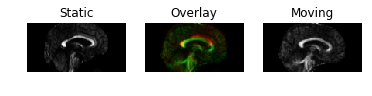

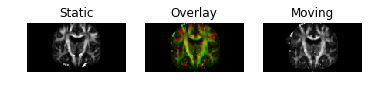

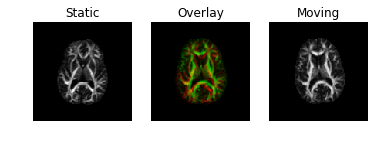

In [56]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
'datasinker/nonlinear_datasink/qc/fa/qc_movreslice/Ttensor_avs_resampled_fa.nii.gz')

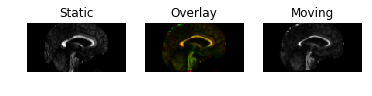

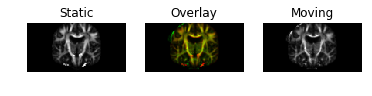

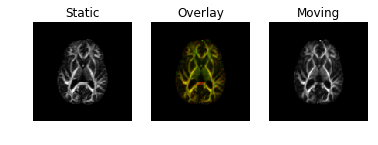

In [57]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
'datasinker/nonlinear_datasink/qc/fa/qc_post/Ttensor_avs_resampled_diffeoxfmd_fa.nii.gz')

### Adult fixed Child moving

In [42]:
nonlinear_wf_child = pe.Workflow(name="nonlinear_wf_child", 
                              base_dir="working_WFtest")

nonlinear_wf_child.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf_child.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file', datasink2, 'warped_file.@file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file_xfm', datasink2, 'warp_xfm.@xfm')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.fixed_resliced', datasink2, 'qc.resliced.fixed.@im')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.moving_resliced', datasink2, 'qc.resliced.moving.@im')


nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf_child.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf_child.connect(fa_out, 'out_file', datasink2, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf_child.connect(fa_in, 'out_file', datasink2, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf_child.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf_child.connect(fa_fix, 'out_file', datasink2, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf_child.connect(fa_mov, 'out_file', datasink2, 'qc.fa.qc_movreslice.@im')

In [43]:
nonlinear_wf_child.inputs.inputnode.fixed_file = fixed_tensor
nonlinear_wf_child.inputs.inputnode.moving_file = child_example
nonlinear_wf_child.run()

180429-00:20:54,850 workflow INFO:
	 Workflow nonlinear_wf_child settings: ['check', 'execution', 'logging', 'monitoring']
180429-00:20:54,863 workflow INFO:
	 Running serially.
180429-00:20:54,865 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/origin_node_moving".
180429-00:20:54,873 workflow INFO:
	 [Node] Running "origin_node_moving" ("nipype.interfaces.dtitk.utils.TVAdjustVoxSp"), a CommandLine Interface with command:
TVAdjustVoxelspace -in /Users/kesshijordan/ref_data/test_tensors/child1_SC_EC_tensor.nii.gz -origin 0 0 0 -out child1_SC_EC_tensor_avs.nii.gz
180429-00:20:55,3 interface INFO:
	 stdout 2018-04-29T00:20:55.002856:Reading /Users/kesshijordan/ref_data/test_tensors/child1_SC_EC_tensor.nii.gz ... Done in 0.045201s
180429-00:20:55,151 interface INFO:
	 stdout 2018-04-29T00:20:55.151169:input voxelspace : size: 100x100x60, voxel size: 2.2x2.2x2.2, 

180429-00:20:59,450 interface INFO:
	 stdout 2018-04-29T00:20:59.450866:Gaussian smoothing: sigma = [0.736, 0.736, 0.736] ... Done in 0.384s
180429-00:20:59,517 interface INFO:
	 stdout 2018-04-29T00:20:59.517774:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/rigid_node/child1_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.0651s
180429-00:21:00,19 interface INFO:
	 stdout 2018-04-29T00:21:00.019464:Gaussian smoothing: sigma = [0.736, 0.736, 0.736] ... Done in 0.311s
180429-00:21:00,240 interface INFO:
	 stdout 2018-04-29T00:21:00.240921:Initial Difference = 5.33e+05
180429-00:21:00,242 interface INFO:
	 stdout 2018-04-29T00:21:00.240921:initial estimate provided by center of mass alignment
180429-00:21:00,282 interface INFO:
	 stdout 2018-04-29T00:21:00.282082:cgm optimizer ftol = 0.01
180429-00:21:00,479 interface INFO:
	 stdout 2018-04-29T00:21:00.479160:both iteration 0 : 4.79e+05
180429-00:21:01,94 interface INFO:
	 stdout 2018-04-29

180429-00:21:07,242 interface INFO:
	 stdout 2018-04-29T00:21:07.240784:interpolation option is LEI
180429-00:21:07,243 interface INFO:
	 stdout 2018-04-29T00:21:07.240784:reorientOption = PPD
180429-00:21:07,310 interface INFO:
	 stdout 2018-04-29T00:21:07.310274:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/affine_node/child1_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.069193s
180429-00:21:07,486 interface INFO:
	 stdout 2018-04-29T00:21:07.486418:trans (inverse) applied = [-0.919, -11.170,  9.435]
180429-00:21:07,487 interface INFO:
	 stdout 2018-04-29T00:21:07.486418:[ 1.054, -0.055,  0.001;  0.042,  1.005,  0.036; -0.010, -0.072,  1.021]
180429-00:21:07,488 interface INFO:
	 stdout 2018-04-29T00:21:07.486418:reading output volume specification from /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/affine_node/Ptensor_avs_resampled.nii.gz
180429-00:21:08,63 interface INFO:
	 stdout 2018-04-29T

180429-00:21:23,980 interface INFO:
	 stdout 2018-04-29T00:21:23.980768:iter 4: sum = 3769.12, img = 60391.6, prior = 631.71, reg = 2061.31
180429-00:21:24,980 interface INFO:
	 stdout 2018-04-29T00:21:24.980456:iter 5: sum = 3749.74, img = 59591.4, prior = 816.668, reg = 2314.71
180429-00:21:25,814 interface INFO:
	 stdout 2018-04-29T00:21:25.814185:iter 6: sum = 3740.5, img = 59272.2, prior = 914.163, reg = 2318.87
180429-00:21:26,692 interface INFO:
	 stdout 2018-04-29T00:21:26.692104:iter 7: sum = 3734.04, img = 59125.6, prior = 973.587, reg = 2228.8
180429-00:21:27,190 interface INFO:
	 stdout 2018-04-29T00:21:27.190289:iter = 56, iterGrad = 8
180429-00:21:27,191 interface INFO:
	 stdout 2018-04-29T00:21:27.190289:after : sum = 3731.11, img = 59119.4, prior = 964.162, reg = 2188.39
180429-00:21:27,192 interface INFO:
	 stdout 2018-04-29T00:21:27.190289:Level 4
180429-00:21:27,193 interface INFO:
	 stdout 2018-04-29T00:21:27.190289:Piecewise Affine Setup: size = 32, 32, 16; vsize =

180429-00:22:51,376 interface INFO:
	 stdout 2018-04-29T00:22:51.375060:matching the center of the old and the new voxel spaces
180429-00:22:52,250 interface INFO:
	 stdout 2018-04-29T00:22:52.250180:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_jac_mask.nii.gz ... Done in 0.177824s
180429-00:22:52,641 interface INFO:
	 stdout 2018-04-29T00:22:52.641833:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:22:53,204 interface INFO:
	 stdout 2018-04-29T00:22:53.204006:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 0.560664s
180429-00:23:09,559 interface INFO:
	 stdout 2018-04-29T00:23:09.559052:outFile = /Use

180429-00:23:35,962 interface INFO:
	 stdout 2018-04-29T00:23:35.961969:iter 3: sum = 2800.11, img = 45033.8, prior = 490.519, reg = 1498.31
180429-00:23:37,116 interface INFO:
	 stdout 2018-04-29T00:23:37.116890:iter 4: sum = 2790.08, img = 44507.9, prior = 585.147, reg = 1859.43
180429-00:23:38,262 interface INFO:
	 stdout 2018-04-29T00:23:38.262153:iter 5: sum = 2781.27, img = 44228, prior = 682.955, reg = 1836.9
180429-00:23:39,441 interface INFO:
	 stdout 2018-04-29T00:23:39.441552:iter 6: sum = 2776.19, img = 44107.4, prior = 745.244, reg = 1740.8
180429-00:23:40,147 interface INFO:
	 stdout 2018-04-29T00:23:40.147634:iter = 57, iterGrad = 7
180429-00:23:40,148 interface INFO:
	 stdout 2018-04-29T00:23:40.147634:after : sum = 2774.51, img = 44121.3, prior = 736.009, reg = 1694.35
180429-00:23:40,149 interface INFO:
	 stdout 2018-04-29T00:23:40.149795:Level 5
180429-00:23:40,150 interface INFO:
	 stdout 2018-04-29T00:23:40.149795:Piecewise Affine Setup: size = 64, 64, 32; vsize = 

180429-00:25:06,604 interface INFO:
	 stdout 2018-04-29T00:25:06.602478:transFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:25:06,605 interface INFO:
	 stdout 2018-04-29T00:25:06.602478:df option is FD
180429-00:25:06,606 interface INFO:
	 stdout 2018-04-29T00:25:06.602478:interpolation option is LEI
180429-00:25:06,606 interface INFO:
	 stdout 2018-04-29T00:25:06.602478:reorientOption = PPD
180429-00:25:06,666 interface INFO:
	 stdout 2018-04-29T00:25:06.666772:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff.nii.gz ... Done in 0.064153s
180429-00:25:07,404 interface INFO:
	 stdout 2018-04-29T00:25:07.404853:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_af

180429-00:25:42,807 interface INFO:
	 stdout 2018-04-29T00:25:42.807053:iter 4: sum = 2428.02, img = 38300.8, prior = 466.54, reg = 2895.32
180429-00:25:44,817 interface INFO:
	 stdout 2018-04-29T00:25:44.817565:iter 5: sum = 2421.04, img = 38142.1, prior = 510.355, reg = 2865.18
180429-00:25:46,877 interface INFO:
	 stdout 2018-04-29T00:25:46.877579:iter 6: sum = 2411.34, img = 37967, prior = 615.268, reg = 2627.84
180429-00:25:48,924 interface INFO:
	 stdout 2018-04-29T00:25:48.924320:iter 7: sum = 2404.91, img = 37865.9, prior = 714.263, reg = 2369.24
180429-00:25:50,950 interface INFO:
	 stdout 2018-04-29T00:25:50.950016:iter 8: sum = 2399.77, img = 37694, prior = 781.868, reg = 2361.9
180429-00:25:52,999 interface INFO:
	 stdout 2018-04-29T00:25:52.999737:iter 9: sum = 2394.09, img = 37343.7, prior = 866.771, reg = 2628.88
180429-00:25:55,48 interface INFO:
	 stdout 2018-04-29T00:25:55.048458:iter 10: sum = 2389.4, img = 37063.6, prior = 937.719, reg = 2830.03
180429-00:25:56,490 

180429-00:27:02,790 interface INFO:
	 stdout 2018-04-29T00:27:02.790391:iteration 3 done
180429-00:27:02,791 interface INFO:
	 stdout 2018-04-29T00:27:02.790391:
180429-00:27:02,792 interface INFO:
	 stdout 2018-04-29T00:27:02.790391:
180429-00:27:02,793 interface INFO:
	 stdout 2018-04-29T00:27:02.793865:iteration 4 begins ...
180429-00:27:02,806 interface INFO:
	 stdout 2018-04-29T00:27:02.806696:Similarity Measure : DDS, Reorient Option : FS
180429-00:27:02,866 interface INFO:
	 stdout 2018-04-29T00:27:02.865992:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/reslice_node_pow2/Ptensor_avs_resampled.nii.gz ... Done in 0.059148s
180429-00:27:03,116 interface INFO:
	 stdout 2018-04-29T00:27:03.116367:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_diffeo.nii.gz ... Done in 0.065128s
180429-00:27:03,302 interface INFO:
	 stdout 2018-04-29T00:27:

180429-00:27:57,478 interface INFO:
	 stdout 2018-04-29T00:27:57.478576:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_diffeo.df.nii.gz ... Done in 0.520046s
180429-00:28:05,705 interface INFO:
	 stdout 2018-04-29T00:28:05.705611:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz ... Done in 4.044s
180429-00:28:05,831 interface INFO:
	 stdout 2018-04-29T00:28:05.831413:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:28:06,394 interface INFO:
	 stdout 2018-04-29T00:28:06.394335:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff

180429-00:28:54,50 interface INFO:
	 stdout 2018-04-29T00:28:54.050297:iter 4: sum = 2077.35, img = 32911, prior = 445.726, reg = 3164.3
180429-00:28:56,171 interface INFO:
	 stdout 2018-04-29T00:28:56.171035:iter 5: sum = 2071.84, img = 32799.1, prior = 480.012, reg = 3128.96
180429-00:28:58,448 interface INFO:
	 stdout 2018-04-29T00:28:58.448804:iter 6: sum = 2064.17, img = 32678.2, prior = 568.54, reg = 2890.19
180429-00:29:00,798 interface INFO:
	 stdout 2018-04-29T00:29:00.798910:iter 7: sum = 2059.28, img = 32628.8, prior = 647.886, reg = 2611.71
180429-00:29:02,891 interface INFO:
	 stdout 2018-04-29T00:29:02.891459:iter 8: sum = 2055.82, img = 32541.2, prior = 691.271, reg = 2578.19
180429-00:29:04,293 interface INFO:
	 stdout 2018-04-29T00:29:04.293947:iter = 73, iterGrad = 9
180429-00:29:04,294 interface INFO:
	 stdout 2018-04-29T00:29:04.293947:after : sum = 2053.72, img = 32484.5, prior = 686.788, reg = 2643.73
180429-00:29:04,296 interface INFO:
	 stdout 2018-04-29T00:29:0

180429-00:30:00,670 interface INFO:
	 stdout 2018-04-29T00:30:00.669998:Similarity Measure : DDS, Reorient Option : FS
180429-00:30:00,732 interface INFO:
	 stdout 2018-04-29T00:30:00.732452:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/reslice_node_pow2/Ptensor_avs_resampled.nii.gz ... Done in 0.062158s
180429-00:30:00,979 interface INFO:
	 stdout 2018-04-29T00:30:00.979893:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_diffeo.nii.gz ... Done in 0.061891s
180429-00:30:01,159 interface INFO:
	 stdout 2018-04-29T00:30:01.159423:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/mask_node/Ptensor_avs_resampled_thrbin.nii.gz ... Done in 0.003687s
180429-00:30:01,358 interface INFO:
	 stdout 2018-04-29T00:30:01.358802:starting level 5, ending level 5
180429-00:30:01,359 interface INFO:
	 stdout 2018-04

180429-00:31:10,677 interface INFO:
	 stdout 2018-04-29T00:31:10.676291:outFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_diffeo_current.nii.gz
180429-00:31:10,678 interface INFO:
	 stdout 2018-04-29T00:31:10.676291:transFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff_to_Ptensor_avs_resampled.5.df.nii.gz
180429-00:31:10,679 interface INFO:
	 stdout 2018-04-29T00:31:10.676291:df option is FD
180429-00:31:10,680 interface INFO:
	 stdout 2018-04-29T00:31:10.676291:interpolation option is LEI
180429-00:31:10,681 interface INFO:
	 stdout 2018-04-29T00:31:10.676291:reorientOption = PPD
180429-00:31:10,742 interface INFO:
	 stdout 2018-04-29T00:31:10.742154:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/diffeo_node/child1_SC_EC_tensor_avs_resampled_aff.nii

180429-00:31:32,572 interface INFO:
	 stdout 2018-04-29T00:31:32.572626:Computing the fractional anisotropy map ... Done in 0.0173s
180429-00:31:32,636 interface INFO:
	 stdout 2018-04-29T00:31:32.636292:Writing child1_SC_EC_tensor_avs_resampled_fa.nii.gz ... Done in 0.044579s
180429-00:31:32,721 workflow INFO:
	 [Node] Finished "linear_wf.fa_mov".
180429-00:31:32,722 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_in" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/fa_in".
180429-00:31:32,724 workflow INFO:
	 [Node] Cached "linear_wf.fa_in" - collecting precomputed outputs
180429-00:31:32,724 workflow INFO:
	 [Node] "linear_wf.fa_in" found cached.
180429-00:31:32,725 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_out" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/fa_out".
180429-00:31:32,727 workflow INFO:
	 [Node] Outdated cache found for "linear_wf.fa_out".
180429-00:31:32,734 workflow INFO:
	 [Node] Running "fa_out" ("nipype.inte

Pre Registration

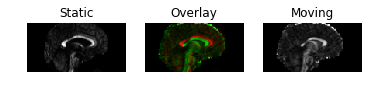

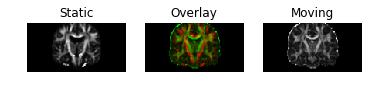

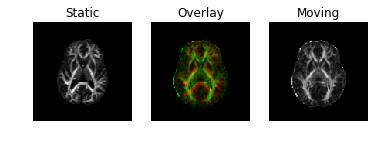

In [52]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
       'datasinker/nonlinear_datasink/qc/fa/qc_movreslice/child1_SC_EC_tensor_avs_resampled_fa.nii.gz')

Post Registration (Nonlinear)

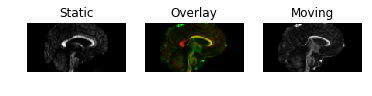

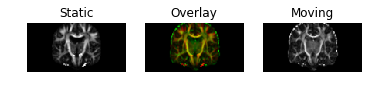

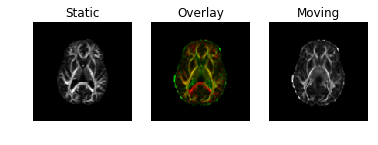

In [53]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
       'datasinker/nonlinear_datasink/qc/fa/qc_post/child1_SC_EC_tensor_avs_resampled_diffeoxfmd_fa.nii.gz')

## Child fixed child moving

In [44]:
nonlinear_wf_child2 = pe.Workflow(name="nonlinear_wf_child2", 
                              base_dir="working_WFtest_child")

nonlinear_wf_child2.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf_child2.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file', datasink3, 'warped_file.@file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file_xfm', datasink3, 'warp_xfm.@xfm')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.fixed_resliced', datasink3, 'qc.resliced.fixed.@im')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.moving_resliced', datasink3, 'qc.resliced.moving.@im')


nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf_child2.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf_child2.connect(fa_out, 'out_file', datasink3, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf_child2.connect(fa_in, 'out_file', datasink3, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf_child2.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf_child2.connect(fa_fix, 'out_file', datasink3, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf_child2.connect(fa_mov, 'out_file', datasink3, 'qc.fa.qc_movreslice.@im')

In [45]:
nonlinear_wf_child2.inputs.inputnode.fixed_file = child_example
nonlinear_wf_child2.inputs.inputnode.moving_file = child_example2
nonlinear_wf_child2.run()

180429-00:31:33,438 workflow INFO:
	 Workflow nonlinear_wf_child2 settings: ['check', 'execution', 'logging', 'monitoring']
180429-00:31:33,455 workflow INFO:
	 Running serially.
180429-00:31:33,456 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child2.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/origin_node_moving".
180429-00:31:33,460 workflow INFO:
	 [Node] Running "origin_node_moving" ("nipype.interfaces.dtitk.utils.TVAdjustVoxSp"), a CommandLine Interface with command:
TVAdjustVoxelspace -in /Users/kesshijordan/ref_data/test_tensors/child2_SC_EC_tensor.nii.gz -origin 0 0 0 -out child2_SC_EC_tensor_avs.nii.gz
180429-00:31:33,575 interface INFO:
	 stdout 2018-04-29T00:31:33.575209:Reading /Users/kesshijordan/ref_data/test_tensors/child2_SC_EC_tensor.nii.gz ... Done in 0.058748s
180429-00:31:33,727 interface INFO:
	 stdout 2018-04-29T00:31:33.727456:input voxelspace : size: 110x110x69, voxel size: 2x

180429-00:31:37,735 interface INFO:
	 stdout 2018-04-29T00:31:37.735777:sampling step size = [2, 2, 2]
180429-00:31:38,71 interface INFO:
	 stdout 2018-04-29T00:31:38.071030:Gaussian smoothing: sigma = [0.645, 0.645, 0.645] ... Done in 0.333s
180429-00:31:38,129 interface INFO:
	 stdout 2018-04-29T00:31:38.129525:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/rigid_node/child2_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.0578s
180429-00:31:38,658 interface INFO:
	 stdout 2018-04-29T00:31:38.658008:Gaussian smoothing: sigma = [0.645, 0.645, 0.645] ... Done in 0.341s
180429-00:31:38,878 interface INFO:
	 stdout 2018-04-29T00:31:38.878869:Initial Difference = 5.29e+05
180429-00:31:38,880 interface INFO:
	 stdout 2018-04-29T00:31:38.878869:initial estimate provided by center of mass alignment
180429-00:31:38,920 interface INFO:
	 stdout 2018-04-29T00:31:38.920258:cgm optimizer ftol = 0.01
180429-00:31:39,89 interface INFO:
	 stdout 

180429-00:31:46,53 interface INFO:
	 stdout 2018-04-29T00:31:46.053132:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/affine_node/child2_SC_EC_tensor_avs_resampled.nii.gz
180429-00:31:46,54 interface INFO:
	 stdout 2018-04-29T00:31:46.053132:outFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/affine_node/child2_SC_EC_tensor_avs_resampled_aff.nii.gz
180429-00:31:46,55 interface INFO:
	 stdout 2018-04-29T00:31:46.053132:interpolation option is LEI
180429-00:31:46,56 interface INFO:
	 stdout 2018-04-29T00:31:46.053132:reorientOption = PPD
180429-00:31:46,118 interface INFO:
	 stdout 2018-04-29T00:31:46.118904:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/affine_node/child2_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.064897s
180429-00:31:46,306 interface INFO:
	 stdout 2018-04-29T00:31:46.306777:trans (inverse) applied = [-9

180429-00:31:58,834 interface INFO:
	 stdout 2018-04-29T00:31:58.834603:iter 2: sum = 5224.3, img = 86095.9, prior = 373.202, reg = 530.811
180429-00:31:59,703 interface INFO:
	 stdout 2018-04-29T00:31:59.703731:iter 3: sum = 5205.15, img = 85419.4, prior = 412.9, reg = 967.405
180429-00:32:00,396 interface INFO:
	 stdout 2018-04-29T00:32:00.396110:iter 4: sum = 5192.2, img = 84862.8, prior = 476.88, reg = 1318.65
180429-00:32:01,270 interface INFO:
	 stdout 2018-04-29T00:32:01.270531:iter 5: sum = 5176.48, img = 84352.3, prior = 582.62, reg = 1427.03
180429-00:32:02,4 interface INFO:
	 stdout 2018-04-29T00:32:02.004118:iter 6: sum = 5169.53, img = 84169.5, prior = 633.164, reg = 1400.98
180429-00:32:02,434 interface INFO:
	 stdout 2018-04-29T00:32:02.434125:iter = 44, iterGrad = 7
180429-00:32:02,435 interface INFO:
	 stdout 2018-04-29T00:32:02.434125:after : sum = 5166.66, img = 84188.4, prior = 626.089, reg = 1318.87
180429-00:32:02,436 interface INFO:
	 stdout 2018-04-29T00:32:02.4

180429-00:33:40,652 interface INFO:
	 stdout 2018-04-29T00:33:40.652394:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_jac_mask.nii.gz ... Done in 0.248079s
180429-00:33:41,192 interface INFO:
	 stdout 2018-04-29T00:33:41.192932:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz
180429-00:33:42,71 interface INFO:
	 stdout 2018-04-29T00:33:42.071094:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz ... Done in 0.819435s
180429-00:34:02,599 interface INFO:
	 stdout 2018-04-29T00:34:02.599110:outFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/Diff

180429-00:34:28,292 interface INFO:
	 stdout 2018-04-29T00:34:28.292181:iter 0: sum = 4686.16, img = 76909.4, prior = 306.96, reg = 1221.51
180429-00:34:30,447 interface INFO:
	 stdout 2018-04-29T00:34:30.447709:iter 1: sum = 4649.96, img = 76402.6, prior = 284.332, reg = 1117.13
180429-00:34:32,514 interface INFO:
	 stdout 2018-04-29T00:34:32.514704:iter 2: sum = 4633.82, img = 76218.4, prior = 273.905, reg = 1001.76
180429-00:34:34,489 interface INFO:
	 stdout 2018-04-29T00:34:34.489269:iter 3: sum = 4604.73, img = 75290.8, prior = 278.762, reg = 1727.55
180429-00:34:36,483 interface INFO:
	 stdout 2018-04-29T00:34:36.483680:iter 4: sum = 4589.58, img = 74729, prior = 314.209, reg = 2154.31
180429-00:34:38,715 interface INFO:
	 stdout 2018-04-29T00:34:38.715145:iter 5: sum = 4581.56, img = 74460.5, prior = 365.424, reg = 2251.14
180429-00:34:40,530 interface INFO:
	 stdout 2018-04-29T00:34:40.530642:iter = 49, iterGrad = 6
180429-00:34:40,533 interface INFO:
	 stdout 2018-04-29T00:34

180429-00:36:08,225 interface INFO:
	 stdout 2018-04-29T00:36:08.225709:IMAGE SIMILARITY: after previous iteration = 87827 after current iteration = 83720.9
180429-00:36:08,262 interface INFO:
	 stdout 2018-04-29T00:36:08.262224:iteration 2 done
180429-00:36:08,263 interface INFO:
	 stdout 2018-04-29T00:36:08.262224:
180429-00:36:08,264 interface INFO:
	 stdout 2018-04-29T00:36:08.262224:
180429-00:36:08,265 interface INFO:
	 stdout 2018-04-29T00:36:08.265561:iteration 3 begins ...
180429-00:36:08,279 interface INFO:
	 stdout 2018-04-29T00:36:08.279175:Similarity Measure : DDS, Reorient Option : FS
180429-00:36:08,341 interface INFO:
	 stdout 2018-04-29T00:36:08.341300:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/reslice_node_pow2/child1_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.061299s
180429-00:36:08,602 interface INFO:
	 stdout 2018-04-29T00:36:08.602505:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_c

180429-00:37:11,706 interface INFO:
	 stdout 2018-04-29T00:37:11.706322:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz ... Done in 4.24s
180429-00:37:11,879 interface INFO:
	 stdout 2018-04-29T00:37:11.879045:computing the deformation field: d2*d1: x -> d1(x) + d2(x + d1(x))
180429-00:37:12,645 interface INFO:
	 stdout 2018-04-29T00:37:12.645867:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz ... Done in 0.712094s
180429-00:37:14,642 interface INFO:
	 stdout 2018-04-29T00:37:14.642296:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_diffeo.df.nii.gz ... Done in 0.806166s
180429-00:37

180429-00:38:12,860 interface INFO:
	 stdout 2018-04-29T00:38:12.860521:iter 0: sum = 4309.08, img = 71010.8, prior = 227.012, reg = 1162.2
180429-00:38:15,40 interface INFO:
	 stdout 2018-04-29T00:38:15.040447:iter 1: sum = 4279.1, img = 70510.6, prior = 211.389, reg = 1202.32
180429-00:38:17,104 interface INFO:
	 stdout 2018-04-29T00:38:17.104883:iter 2: sum = 4265.16, img = 70348.6, prior = 205.446, reg = 1066.5
180429-00:38:19,484 interface INFO:
	 stdout 2018-04-29T00:38:19.484329:iter 3: sum = 4240.52, img = 69531.8, prior = 228.333, reg = 1879.57
180429-00:38:22,261 interface INFO:
	 stdout 2018-04-29T00:38:22.261761:iter 4: sum = 4229.29, img = 69105, prior = 267.316, reg = 2295.58
180429-00:38:24,569 interface INFO:
	 stdout 2018-04-29T00:38:24.569630:iter 5: sum = 4223.03, img = 68864.9, prior = 322.416, reg = 2448.74
180429-00:38:26,440 interface INFO:
	 stdout 2018-04-29T00:38:26.440574:iter = 49, iterGrad = 6
180429-00:38:26,441 interface INFO:
	 stdout 2018-04-29T00:38:26

180429-00:39:57,802 interface INFO:
	 stdout 2018-04-29T00:39:57.802223:iteration 4 done
180429-00:39:57,803 interface INFO:
	 stdout 2018-04-29T00:39:57.802223:
180429-00:39:57,805 interface INFO:
	 stdout 2018-04-29T00:39:57.805301:
180429-00:39:57,806 interface INFO:
	 stdout 2018-04-29T00:39:57.805301:iteration 5 begins ...
180429-00:39:57,821 interface INFO:
	 stdout 2018-04-29T00:39:57.821093:Similarity Measure : DDS, Reorient Option : FS
180429-00:39:57,892 interface INFO:
	 stdout 2018-04-29T00:39:57.892069:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/reslice_node_pow2/child1_SC_EC_tensor_avs_resampled.nii.gz ... Done in 0.069547s
180429-00:39:58,166 interface INFO:
	 stdout 2018-04-29T00:39:58.166039:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_diffeo.nii.gz ... Done in 0.067517s
180429-00:39:58,371 interface INFO:


180429-00:41:06,766 interface INFO:
	 stdout 2018-04-29T00:41:06.766582:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz ... Done in 0.810747s
180429-00:41:27,145 interface INFO:
	 stdout 2018-04-29T00:41:27.144992:outFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df_jac.nii.gz
180429-00:41:32,674 interface INFO:
	 stdout 2018-04-29T00:41:32.674474:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df_jac.nii.gz ... Done in 5.08678s
180429-00:41:35,433 interface INFO:
	 stdout 2018-04-29T00:41:35.433682:JACOBIAN STATISTICS: after previous iteration mean = 1.0

180429-00:42:18,125 interface INFO:
	 stdout 2018-04-29T00:42:18.124942:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 2.64s
180429-00:42:20,533 interface INFO:
	 stdout 2018-04-29T00:42:20.533737:Gaussian smoothing: sigma = [   1,    1,    1] ... Done in 2.4s
180429-00:42:20,595 interface INFO:
	 stdout 2018-04-29T00:42:20.595850:maxNorm = 1.65	iterations = 3
180429-00:42:20,652 interface INFO:
	 stdout 2018-04-29T00:42:20.652805:Voxelwise scaling /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_SC_EC_tensor_avs_resampled.5.df.nii.gz by 0.125 ... Done in 0.056s
180429-00:42:34,333 interface INFO:
	 stdout 2018-04-29T00:42:34.333422:. . . 
180429-00:42:39,795 interface INFO:
	 stdout 2018-04-29T00:42:39.794896:Writing /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/diffeo_node/child2_SC_EC_tensor_avs_resampled_aff_to_child1_S

180429-00:43:39,929 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:inFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/reslice_node_moving/child2_SC_EC_tensor_avs_resampled.nii.gz
180429-00:43:39,932 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:outFile = child2_SC_EC_tensor_avs_resampled_diffeoxfmd.nii.gz
180429-00:43:39,933 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:transFile = /Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/compose_xfm_node/child2_SC_EC_tensor_avs_resampled_aff_diffeo_affdf.df.nii.gz
180429-00:43:39,934 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:df option is FD
180429-00:43:39,937 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:interpolation option is LEI
180429-00:43:39,938 interface INFO:
	 stdout 2018-04-29T00:43:39.928669:reorientOption = PPD
180429-00:43:40,3 interface INFO:
	 stdout 2018-04-29T00:43:40.003668:Reading /Users/kesshijo

Pre Registration

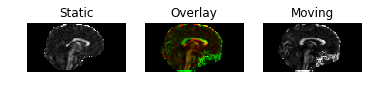

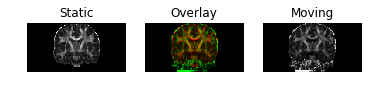

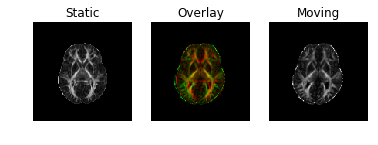

In [49]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_fixreslice/child1_SC_EC_tensor_avs_resampled_fa.nii.gz')[0],
      glob('datasinker/childchild_datasink/qc/fa/qc_movreslice/child2_SC_EC_tensor_avs_resampled_fa.nii.gz')[0])

Post Registration (Nonlinear)

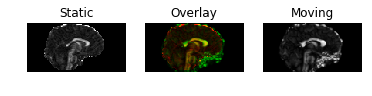

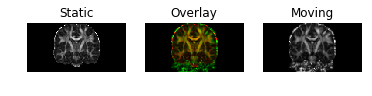

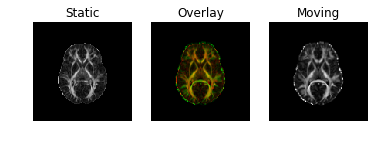

In [50]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_fixreslice/child1_SC_EC_tensor_avs_resampled_fa.nii.gz')[0],
      glob('datasinker/childchild_datasink/qc/fa/qc_post/child2_SC_EC_tensor_avs_resampled_diffeoxfmd_fa.nii.gz')[0])